In [22]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [23]:
#because the images are so small and the dataset is sufficiently large, we won't need to apply any image transformations

In [24]:
import torchvision
from torchvision import datasets

train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None,
    download=True,
)
test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None,
    download=True,
)

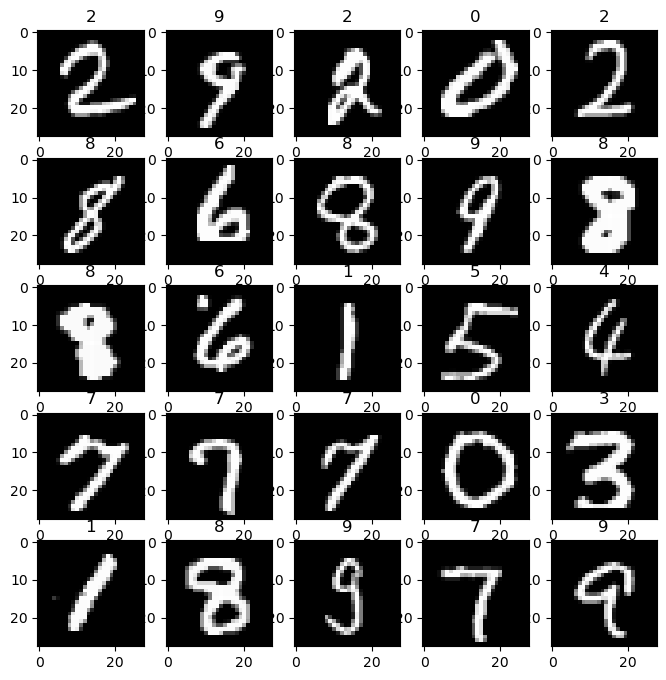

In [25]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))
row, col = 5,5

for i in range(1, row * col + 1):
  index = torch.randint(high=len(train_dataset),size=(1,)).item()
  img, label = train_dataset[index]
  fig.add_subplot(row, col, i)
  plt.imshow(img.squeeze(), cmap='gray')
  plt.title(label)

In [26]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

In [27]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=False,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=32,
    shuffle=False,
)

In [28]:
next(iter(train_dataloader))

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ..

In [29]:
#VGG 16 but with only 3 conv blocks instead of 5

import torch.nn as nn
class VGG_8(nn.Module):
  def __init__(self,
               in_channels,
               hidden_layers,
               out_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        # N x 1 x 28 x 28
        nn.Conv2d(in_channels, hidden_layers, stride=1, padding=1, kernel_size=3),
        nn.ReLU(),
        # N x hidden x 28 x 28
        nn.Conv2d(hidden_layers, hidden_layers, stride=1, padding=1, kernel_size=3),
        nn.ReLU(),
        # N x hidden x 28 x 28
        nn.Conv2d(hidden_layers, hidden_layers, stride=1, padding=1, kernel_size=3),
        nn.ReLU(),
        # N x hidden x 28 x 28
        nn.MaxPool2d(kernel_size=2)
        # N x hidden x 14 x 14
    )
    self.conv_block_2 = nn.Sequential(
        # N x hidden x 14 x 14
        nn.Conv2d(hidden_layers, hidden_layers, stride=1, padding=1, kernel_size=3),
        nn.ReLU(),
        # N x hidden x 14 x 14
        nn.Conv2d(hidden_layers, hidden_layers, stride=1, padding=1, kernel_size=3),
        nn.ReLU(),
        # N x hidden x 14 x 14
        nn.Conv2d(hidden_layers, hidden_layers, stride=1, padding=1, kernel_size=3),
        nn.ReLU(),
        # N x hidden x 14 x 14
        nn.MaxPool2d(kernel_size=2)
        # N x hidden x 7 x 7
    )
    self.fully_connected = nn.Sequential(
        # N x hidden x 7 x 7
        nn.Flatten(),
        # N x hidden*49
        nn.Linear(hidden_layers * 49,
                  out_shape)
        # N x 10
    )

  def forward(self, x):
    # N x 1 x 28 x 28
    x = self.conv_block_1(x)
    # N x hidden x 14 x 14
    x = self.conv_block_2(x)
    # N x hidden x 7 x 7
    x = self.fully_connected(x)
    # N x 10
    return x

In [30]:
from torchmetrics import Accuracy

loss_fn = torch.nn.CrossEntropyLoss()
acc_fn = Accuracy(task='multiclass', num_classes=10).to(device)

In [31]:
X, y = next(iter(test_dataloader))
X.shape, y.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [32]:
#testing
model_0 = VGG_8(in_channels=1,
                out_shape=10,
                hidden_layers=16).to(device)

def evaluate_model(model,
                   dataloader,
                   loss_function,
                   acc_function,
                   device):
  model.eval()
  loss = acc = 0
  for batch,(X,y) in enumerate(dataloader):
    with torch.inference_mode():
      X, y = X.to(device), y.to(device)
      logits = model(X)
      preds = logits.softmax(dim=1).argmax(dim=1)

      batch_loss = loss_function(logits, y)
      batch_acc = acc_function(preds, y)

      loss += batch_loss
      acc += batch_acc

  loss = loss / len(dataloader)
  acc = acc / len(dataloader)

  return {
      'model_name' : type(model).__name__,
      'loss' : loss,
      'accuracy' : acc
  }

results_0 = evaluate_model(model_0, test_dataloader, loss_fn, acc_fn, device)
results_0

{'model_name': 'VGG_8',
 'loss': tensor(2.3030, device='cuda:0'),
 'accuracy': tensor(0.1010, device='cuda:0')}

In [33]:
model = VGG_8(in_channels=1,
                out_shape=10,
                hidden_layers=64).to(device)

loss_fn = torch.nn.CrossEntropyLoss().to(device)
acc_fn = Accuracy(task='multiclass', num_classes=10).to(device)
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001)

In [34]:
def train_step(model,
               dataloader,
               loss_function,
               acc_function,
               optimizer,
               device):
  model.train()
  loss = acc = 0
  for batch,(X,y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    logits = model(X)
    preds = logits.softmax(dim=1).argmax(dim=1)



    batch_loss = loss_function(logits.squeeze(), y)
    batch_acc = acc_function(preds, y)

    loss += batch_loss
    acc += batch_acc

    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()

  loss = loss / len(dataloader)
  acc = acc / len(dataloader)

  return loss, acc

In [35]:
def test_step(model,
              dataloader,
              loss_function,
              acc_function,
              device):
  model.eval()
  loss = acc = 0
  for batch,(X,y) in enumerate(dataloader):
    with torch.inference_mode():
      X, y = X.to(device), y.to(device)
      logits = model(X)
      preds = logits.softmax(dim=1).argmax(dim=1)

      batch_loss = loss_function(logits, y)
      batch_acc = acc_function(preds, y)

      loss += batch_loss
      acc += batch_acc

  loss = loss / len(dataloader)
  acc = acc / len(dataloader)

  return loss, acc

In [36]:
from tqdm.auto import tqdm


epochs = 3
results = {
    "train_loss":[],
    "train_acc":[],
    "test_loss":[],
    "test_acc":[]
}

for epoch in tqdm(range(epochs)):
  train_loss, train_acc = train_step(model=model,
                                     dataloader = train_dataloader,
                                     loss_function = loss_fn,
                                     acc_function = acc_fn,
                                     optimizer = optimizer,
                                     device = device)
  test_loss, test_acc = test_step(model=model,
                                  dataloader = test_dataloader,
                                  loss_function = loss_fn,
                                  acc_function = acc_fn,
                                  device = device)

  print("--------")
  print(f"Epoch:{epoch}")
  print(f"train_loss:{train_loss}")
  print(f"train_acc:{train_acc}")
  print(f"test_loss:{test_loss}")
  print(f"test_acc:{test_acc}")

  results["train_loss"].append(train_loss.item())
  results["train_acc"].append(train_acc.item())
  results["test_loss"].append(test_loss.item())
  results["test_acc"].append(test_acc.item())

results

 33%|███▎      | 1/3 [00:39<01:19, 39.82s/it]

--------
Epoch:0
train_loss:0.12795761227607727
train_acc:0.9613000154495239
test_loss:0.051918886601924896
test_acc:0.9822283983230591


 67%|██████▋   | 2/3 [01:19<00:39, 39.61s/it]

--------
Epoch:1
train_loss:0.04447108507156372
train_acc:0.9866999983787537
test_loss:0.05643399804830551
test_acc:0.9814296960830688


100%|██████████| 3/3 [01:59<00:00, 39.67s/it]

--------
Epoch:2
train_loss:0.03154982253909111
train_acc:0.990766704082489
test_loss:0.041367921978235245
test_acc:0.9872204065322876


{'train_loss': [0.12795761227607727, 0.04447108507156372, 0.03154982253909111],
 'train_acc': [0.9613000154495239, 0.9866999983787537, 0.990766704082489],
 'test_loss': [0.051918886601924896,
  0.05643399804830551,
  0.041367921978235245],
 'test_acc': [0.9822283983230591, 0.9814296960830688, 0.9872204065322876]}

In [37]:
results

{'train_loss': [0.12795761227607727, 0.04447108507156372, 0.03154982253909111],
 'train_acc': [0.9613000154495239, 0.9866999983787537, 0.990766704082489],
 'test_loss': [0.051918886601924896,
  0.05643399804830551,
  0.041367921978235245],
 'test_acc': [0.9822283983230591, 0.9814296960830688, 0.9872204065322876]}

In [38]:
results_1 = evaluate_model(model, test_dataloader, loss_fn, acc_fn, device)
results_0, results_1

({'model_name': 'VGG_8',
  'loss': tensor(2.3030, device='cuda:0'),
  'accuracy': tensor(0.1010, device='cuda:0')},
 {'model_name': 'VGG_8',
  'loss': tensor(0.0414, device='cuda:0'),
  'accuracy': tensor(0.9872, device='cuda:0')})

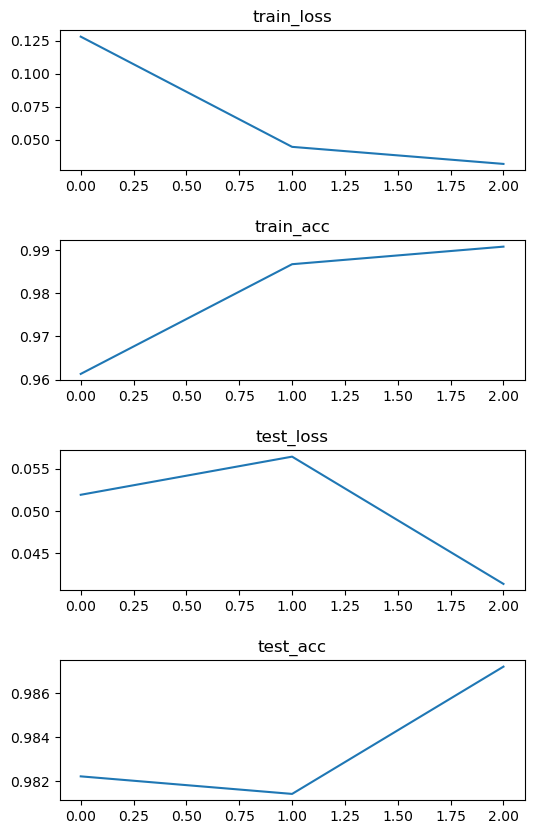

In [39]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6,10))
plt.subplots_adjust(wspace=3, hspace=0.5)

i = 1
for name in results:
  fig.add_subplot(4,1,i)
  plt.title(name)
  plt.plot(results[name])
  i+=1

In [50]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def get_model_preds(model,
                   dataset,
                   device):
  model.eval()
  predictions = []
  for i in range(len(dataset)):
    with torch.inference_mode():
      X, y = dataset[i]
      X = X.unsqueeze(dim=0)
      X, y = X.to(device), y

      logits = model(X)
      prediction = logits.softmax(dim=1).argmax(dim=1)
      predictions.append(prediction.item())
  return predictions

In [52]:
predictions = get_model_preds(model,test_dataset,device)
true_values = test_dataset.targets

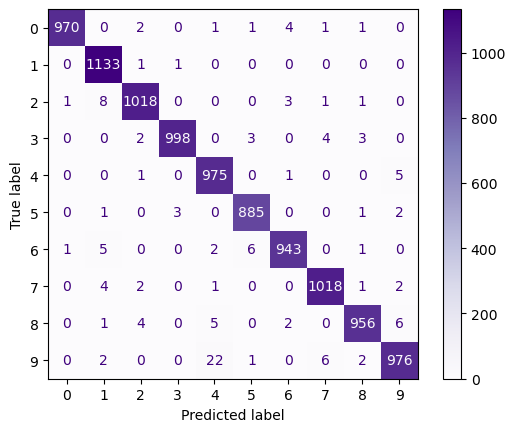

In [59]:
conf_matrix = confusion_matrix(y_true = true_values, y_pred = predictions)
conf_matrix_display = ConfusionMatrixDisplay(conf_matrix)
conf_matrix_display.plot(cmap='Purples')

In [43]:
X, y = next(iter(test_dataloader))
X.shape, y.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [47]:
X, y = test_dataset[0]
X = X.unsqueeze(dim=0)
X.shape, y

(torch.Size([1, 1, 28, 28]), 7)